## MSDS 7331: Data Mining
## Mini Lab: Logistic Regression and SVMs
## Classification Task

The classification task for our data set is to predict whether an H1-B Visa would be certified or not.This is an importatnt task as the companies intending to hire these eployees need to find out if they will ahve enough employees to complete the project or job they need these applicants for and this affects the company's profit and future project acquistion.

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
import pandas as pd
import statsmodels.api as sm 
import numpy as np
import random
from sklearn.model_selection import GridSearchCV
import math

import warnings
warnings.filterwarnings("ignore") # ignore warnings for clean report

### Preparing Data
This is the initial dataset that is divided into 3 groups(certified, certified-withdrawn, denied) for logistic regression purposes we reduce this to 2 groups (certified and denied). this data has been cleaned and outliers removed from the previous lab.

<AxesSubplot:title={'center':'count (target)'}>

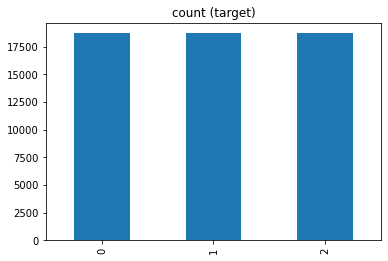

In [2]:
df = pd.read_csv ('Balanced_Visa_Data.csv')
df = df.sample(frac = 1) 
df['CASE_STATUS_CODE'].value_counts().plot(kind='bar', title='count (target)')

In [3]:
df1 = df.loc[(df['CASE_STATUS_CODE']==0) | (df['CASE_STATUS_CODE']==2)] 
df1['CASE_STATUS_CODE'] = np.select([df1.CASE_STATUS_CODE==0],[1],0)
np.unique(df1.CASE_STATUS_CODE)

array([0, 1])

<AxesSubplot:title={'center':'count (target)'}>

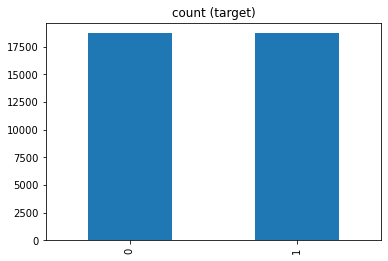

In [4]:
df1['CASE_STATUS_CODE'].value_counts().plot(kind='bar', title='count (target)')

## Create Dummmies
At this point we are removing the categorical columns and replacing them with dummy variable that will 0,1 value for the model. Out target variable is 1 which means certified and 0 which specifies denied. In this phase we also removed some unnecesarry varibale incuding the unit of pay and wage unit of pay which specifies how the salary was recorded for an example weekly, bi-weekly monthly.

In [5]:
df2 = df1.drop(['CASE_STATUS','EMPLOYER_NAME_CODE', 'EMPLOYER_CITY_CODE',
           'SOC_NAME_CODE', 'EMPLOYER_STATE_CODE','WILLFUL_VIOLATOR_CODE',
           'AGENT_REPRESENTING_EMPLOYER_CODE', 'JOB_TITLE_CODE', 'EMPLOYER_STATE',
           'WORKSITE_CITY_CODE', 'WORKSITE_STATE_CODE', 'WORKSITE_STATE',
           'PW_UNIT_OF_PAY_CODE', 'PW_WAGE_LEVEL_CODE', 'WAGE_UNIT_OF_PAY_CODE',
           'H1B_DEPENDENT_CODE', 'SUPPORT_H1B_CODE', 'LABOR_CON_AGREE_CODE',
           'Unnamed: 0','WORKSITE_CITY','EMPLOYER_NAME','PW_UNIT_OF_PAY',
            'EMPLOYER_CITY','WILLFUL_VIOLATOR_CODE', 'WORKSITE_CITY_CODE',
            'SOC_GROUP_Code','SOC_NAME','JOB_TITLE','SOC_GROUP_CODE',
            'WAGE_UNIT_OF_PAY'], axis=1)

In [6]:
WILLFUL_VIOLATOR = pd.get_dummies(df2.WILLFUL_VIOLATOR, prefix='WILL_VIOL',drop_first=True)
df2 = pd.concat([df2, WILLFUL_VIOLATOR], axis=1)

SOC_GROUP = pd.get_dummies(df2['SOC_GROUP'],drop_first=True)
df2 = pd.concat([df2, SOC_GROUP], axis=1)

PW_WAGE_LEVEL = pd.get_dummies(df2.PW_WAGE_LEVEL, prefix='PW_LEVEL',drop_first=True)
df2 = pd.concat([df2, PW_WAGE_LEVEL], axis=1)

AGENT_REPRESENTING_EMPLOYER = pd.get_dummies(df2.AGENT_REPRESENTING_EMPLOYER, prefix='AGENT_REP',drop_first=True)
df2 = pd.concat([df2, AGENT_REPRESENTING_EMPLOYER], axis=1)  

H1B_DEPENDENT = pd.get_dummies(df2.H1B_DEPENDENT, prefix='H1B_DEP',drop_first=True)
df2 = pd.concat([df2, H1B_DEPENDENT], axis=1)

LABOR_CON_AGREE = pd.get_dummies(df2.LABOR_CON_AGREE, prefix='LABOR_CON_AGREE',drop_first=True)
df2 = pd.concat([df2, LABOR_CON_AGREE], axis=1)

SUPPORT_H1B = pd.get_dummies(df2.SUPPORT_H1B, prefix='SUPPORT_H1B',drop_first=True)
df2 = pd.concat([df2, SUPPORT_H1B], axis=1)

In [7]:
df2.shape

(37420, 42)

In [8]:
df3 = df2.drop(['WILLFUL_VIOLATOR','PW_WAGE_LEVEL',
               'H1B_DEPENDENT','LABOR_CON_AGREE',
                'AGENT_REPRESENTING_EMPLOYER','SOC_GROUP','SUPPORT_H1B'], axis=1)
df3.head()

,TOTAL_WORKERS,NEW_EMPLOYMENT,CONTINUED_EMPLOYMENT,CHANGE_PREVIOUS_EMPLOYMENT,NEW_CONCURRENT_EMPLOYMENT,ANNUALIZED_PREVAILING_WAGE,PREVAILING_WAGE,ANNUALIZED_WAGE_RATE_OF_PAY,WAGE_RATE_OF_PAY,DAYS_PROCESS,...,Management,Office and Administrative Support,Personal Care and Service,Production,Sales and Related,Transportation and Material Moving,AGENT_REP_Y,H1B_DEP_Y,LABOR_CON_AGREE_Y,SUPPORT_H1B_Y
20338,3,1,0,0,0,45594.000000,45594.000000,60000.000000,60000.000000,6,...,0,0,0,0,0,0,1,1,1,1
8207,1,0,0,0,0,52541.000000,52541.000000,69805.000000,69805.000000,6,...,0,0,0,0,0,0,0,1,1,1
41668,1,0,0,0,0,76239.195536,76239.195536,75230.102705,75230.102705,5,...,0,0,0,0,0,0,0,1,1,1
10474,1,0,0,0,0,86715.000000,86715.000000,86715.000000,86715.000000,4,...,1,0,0,0,0,0,0,1,1,1
601,1,1,0,0,0,54704.000000,54704.000000,60000.000000,60000.000000,6,...,0,0,0,0,0,0,0,1,1,1


In [9]:
cont_vars = ['TOTAL_WORKERS','ANNUALIZED_PREVAILING_WAGE', 
           'PREVAILING_WAGE', 'ANNUALIZED_WAGE_RATE_OF_PAY',
                'WAGE_RATE_OF_PAY','DAYS_PROCESS']

In [10]:
pd.set_option('display.max_columns', 100)
df3.shape

(37420, 35)

In [11]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37420 entries, 20338 to 47379
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   TOTAL_WORKERS                                   37420 non-null  int64  
 1   NEW_EMPLOYMENT                                  37420 non-null  int64  
 2   CONTINUED_EMPLOYMENT                            37420 non-null  int64  
 3   CHANGE_PREVIOUS_EMPLOYMENT                      37420 non-null  int64  
 4   NEW_CONCURRENT_EMPLOYMENT                       37420 non-null  int64  
 5   ANNUALIZED_PREVAILING_WAGE                      37420 non-null  float64
 6   PREVAILING_WAGE                                 37420 non-null  float64
 7   ANNUALIZED_WAGE_RATE_OF_PAY                     37420 non-null  float64
 8   WAGE_RATE_OF_PAY                                37420 non-null  float64
 9   DAYS_PROCESS                       

### Test/Train split

In [12]:
# divide data set to x and y and Scale data

y = df3['CASE_STATUS_CODE']
x = df3.drop(['CASE_STATUS_CODE'], axis=1)

In [13]:
a = df3['CASE_STATUS_CODE'].values
bb = df3.drop(['CASE_STATUS_CODE'], axis=1)
b = bb.values

x_t = x[:7484]
y_t = y[:7484]

print(x_t.shape)
print(y_t.shape)

(7484, 34)
(7484,)


In [14]:
# create train set
import random
random.seed(0)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=0)
print(y_train.shape)
print(x_test.shape)

(29936,)
(7484, 34)


### Logistic Regression Grid search


In [15]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [16]:
# grid search
params = {
    'penalty':['l2'],        # l1 is Lasso, l2 is Ridge
    'solver':['sag'],
    'C': [0.1,1,10,100]
}

lr = LogisticRegression()
lr_gs = GridSearchCV(lr, params, cv=5, verbose=1).fit(x_train, y_train)

print_results(lr_gs)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
BEST PARAMS: {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}

0.593 (+/-0.011) for {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}
0.593 (+/-0.011) for {'C': 1, 'penalty': 'l2', 'solver': 'sag'}
0.593 (+/-0.011) for {'C': 10, 'penalty': 'l2', 'solver': 'sag'}
0.593 (+/-0.011) for {'C': 100, 'penalty': 'l2', 'solver': 'sag'}


### Logistic Regression Model

Applying a scale it to the entire data before splitting into training and test sets will bias the model evaluation because information would have leaked from the test set to the training set. scikit learn developers recommend using StandardScaler within a Pipeline in order to prevent most risks of data leaking: pipe = make_pipeline(StandardScaler(), LogisticRegression()).

In [17]:
# Create pipeline
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('lg', LogisticRegression(penalty='l2',solver='sag', random_state=0,C=0.1))])
pipe.fit(x_train,y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('lg',
                 LogisticRegression(C=0.1, random_state=0, solver='sag'))])

### 10fold Cross Validation 

In [18]:
# cross validation
random.seed(10)
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 10
cv_object = ShuffleSplit(n_splits=num_cv_iterations,test_size  = 0.2)

In [19]:
# accuracies fom cross validation

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(pipe, x_t, y=y_t, cv=cv_object)
print(accuracies)

[0.84502338 0.84836339 0.83700735 0.83633935 0.84235137 0.8490314
 0.84702739 0.84702739 0.83700735 0.84702739]


In [20]:
pd.set_option('display.max_rows', None)
from sklearn import metrics as mt
iter_num=0
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(b,a)):
    pipe.fit(b[train_indices],a[train_indices])  # train object
    y_hat = pipe.predict(b[test_indices])
    
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(a[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(a[test_indices],y_hat))
    print(classification_report(a[test_indices],y_hat))

====Iteration 0  ====
accuracy 0.8367183324425441
confusion matrix
 [[3100  728]
 [ 494 3162]]
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      3828
           1       0.81      0.86      0.84      3656

    accuracy                           0.84      7484
   macro avg       0.84      0.84      0.84      7484
weighted avg       0.84      0.84      0.84      7484

====Iteration 1  ====
accuracy 0.8399251737039016
confusion matrix
 [[3079  706]
 [ 492 3207]]
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      3785
           1       0.82      0.87      0.84      3699

    accuracy                           0.84      7484
   macro avg       0.84      0.84      0.84      7484
weighted avg       0.84      0.84      0.84      7484

====Iteration 2  ====
accuracy 0.8324425440940674
confusion matrix
 [[3019  699]
 [ 555 3211]]
              precision    recall  f1-score   support

      

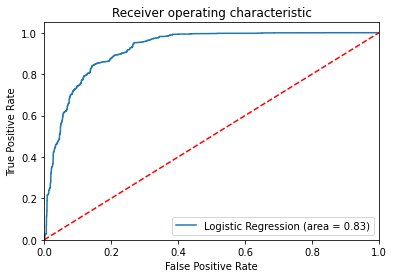

In [21]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, pipe.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, pipe.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Support Vector Machines

In [22]:
# reducing data set size for SVC

df4=df3.sort_values(by=['CASE_STATUS_CODE'])
df4=df4.iloc[13000:, :]
df4=df4.iloc[:11420, :]
df4.shape

(11420, 35)

In [23]:
df4 = df4.sample(frac = 1) 
df4.head(5)

,TOTAL_WORKERS,NEW_EMPLOYMENT,CONTINUED_EMPLOYMENT,CHANGE_PREVIOUS_EMPLOYMENT,NEW_CONCURRENT_EMPLOYMENT,ANNUALIZED_PREVAILING_WAGE,PREVAILING_WAGE,ANNUALIZED_WAGE_RATE_OF_PAY,WAGE_RATE_OF_PAY,DAYS_PROCESS,CASE_STATUS_CODE,WILL_VIOL_Y,"Arts, Design, Entertainment, Sports, and Media",Building and Grounds Cleaning and Maintenance,Business and Financial Operations,Community and Social Service,Computer and Mathematical,Construction and Extraction,"Education, Training, and Library",Food Preparation and Serving Related,Healthcare Practitioners and Technical,Healthcare Support,"Installation, Maintenance, and Repair",Legal,"Life, Physical, and Social Science",Management,Office and Administrative Support,Personal Care and Service,Production,Sales and Related,Transportation and Material Moving,AGENT_REP_Y,H1B_DEP_Y,LABOR_CON_AGREE_Y,SUPPORT_H1B_Y
5228,1,1,0,0,0,63669.000000,63669.000000,64000.000000,64000.000000,6,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
15093,1,0,0,0,0,63398.000000,63398.000000,72000.000000,72000.000000,7,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1
11001,1,0,0,0,0,45136.000000,45136.000000,55910.000000,55910.000000,6,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
44768,1,0,0,0,0,91256.167957,91256.167957,90654.217898,90654.217898,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
51018,1,0,0,0,0,62754.000000,62754.000000,62963.930755,62963.930755,5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1


<AxesSubplot:title={'center':'count (target)'}>

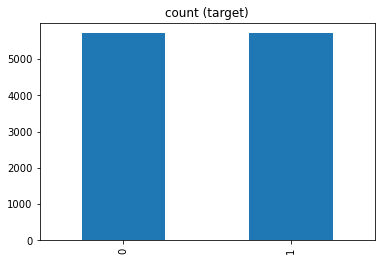

In [24]:
df4['CASE_STATUS_CODE'].value_counts().plot(kind='bar', title='count (target)')

In [25]:
from sklearn import svm

### Test/Train Split for SVM 
The scikit learn SVC model classifier needs a smaller data set to function, due to the requirements of this lab and the capabilities of the scikitlearn model another test train split set has been created this will allow the support vectors to be accessed at the end of the lab.

In [26]:
# Reduced data set preprocessing for SVC
# divide data set to x and y and Scale data
#from sklearn import preprocessing

y = df4['CASE_STATUS_CODE']
x = df4.drop(['CASE_STATUS_CODE'], axis=1)
#x = preprocessing.scale(x) 

a = df4['CASE_STATUS_CODE'].values
bb = df4.drop(['CASE_STATUS_CODE'], axis=1)
b = bb.values
#b = preprocessing.scale(b) 

x_t = x[:2284]
y_t = y[:2284]

print(x.shape)
print(y.shape)

(11420, 34)
(11420,)


In [27]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=0)
print(y_train.shape)
print(x_test.shape)

(9136,)
(2284, 34)


In [28]:
# Grid search
svc = GridSearchCV(svm.SVC(gamma='auto',random_state=89),{
            'C':[1,10,100],
                'kernel':['rbf']}, cv=5, verbose=1,)

sv_gs = svc.fit(x_train, y_train)
print_results(sv_gs)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
BEST PARAMS: {'C': 10, 'kernel': 'rbf'}

0.806 (+/-0.009) for {'C': 1, 'kernel': 'rbf'}
0.806 (+/-0.009) for {'C': 10, 'kernel': 'rbf'}
0.806 (+/-0.009) for {'C': 100, 'kernel': 'rbf'}


In [29]:
# Create pipeline
pipesv = Pipeline([
        ('scale', StandardScaler()),
        ('sv', svm.SVC(C=100,kernel= 'rbf',random_state=89))])
pipesv.fit(x_train,y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('sv', SVC(C=100, random_state=89))])

In [30]:
iter_num=0
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(b,a)):
    pipesv.fit(b[train_indices],a[train_indices])  # train object
    y_hat = pipesv.predict(b[test_indices])
    
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(a[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(a[test_indices],y_hat))
    print(classification_report(a[test_indices],y_hat))

====Iteration 0  ====
accuracy 0.8747810858143608
confusion matrix
 [[ 966  190]
 [  96 1032]]
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      1156
           1       0.84      0.91      0.88      1128

    accuracy                           0.87      2284
   macro avg       0.88      0.88      0.87      2284
weighted avg       0.88      0.87      0.87      2284

====Iteration 1  ====
accuracy 0.897985989492119
confusion matrix
 [[1011  143]
 [  90 1040]]
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      1154
           1       0.88      0.92      0.90      1130

    accuracy                           0.90      2284
   macro avg       0.90      0.90      0.90      2284
weighted avg       0.90      0.90      0.90      2284

====Iteration 2  ====
accuracy 0.8760945709281961
confusion matrix
 [[ 913  160]
 [ 123 1088]]
              precision    recall  f1-score   support

       

In [31]:
random.seed(0)
scaler = StandardScaler()
X = scaler.fit_transform(x)
Y = df4['CASE_STATUS_CODE']
X_train,X_test,y_trained,y_tested = train_test_split(X,Y,test_size=0.2,random_state=0)
sv = svm.SVC(C=100,kernel= 'rbf',random_state=89)
sv.fit(X_train, y_trained)

SVC(C=100, random_state=89)

In [32]:
# Get support vectors themselves
support_vectors = sv.support_vectors_

# Visualize support vectors
#plt.scatter(x_train[:,7], x_train[:,6])
#plt.scatter(support_vectors[:,7], support_vectors[:,6], color='green')
#plt.title('Linearly separable data with support vectors')
#plt.xlabel('X1')
#plt.ylabel('X2')
#plt.show()

In [33]:
# to call the suppport vector foe each variable use the [column index]

svc = sv.support_vectors_
svc.shape

(2429, 34)

In [34]:
len(svc[0])

34

In [35]:
svc[2000]

array([ 4.35722815, -0.46722329, 21.66321124, -0.15874332, -0.06440177,
        0.44851284,  0.41676784,  3.32924196,  2.38570485,  0.79302775,
       -0.03503461, -0.10855168, -0.08556378, -0.18375207, -0.13351147,
        0.45124897, -0.09493257, -0.0967932 , -0.09907165, -0.1021794 ,
       -0.07144743, -0.0779664 , -0.07507188, -0.07144743, -0.11497725,
       -0.03243291, -0.02960446, -0.03243291, -0.03105078,  0.        ,
        1.75334144,  0.43953129,  0.23980268,  0.3930245 ])

## Logistic Regression Weight Interpretation

In [36]:
# predictions for logistic regression
pd.set_option('display.max_rows', None)

lg = LogisticRegression(penalty='l2',solver='sag', random_state=0,C=0.1)
lg.fit(X_train, y_trained)

y_pred = lg.predict(X_test)
coef = lg.coef_

coefs = []
for i in coef[0]:
    coefs.append(round(i,6))

In [37]:
coef = [i for i in coefs]
coef_abs = [abs(i) for i in coefs]
odds = [math.exp(i) for i in coef ]
scale = scaler.scale_
zip_vars = zip(coef,coef_abs,odds,scale,bb.columns) # combine attributes
zip_vars = sorted(zip_vars)

In [38]:
df_weights = pd.DataFrame(zip_vars, columns = ['coef','coef_abs','odds','std_dev','feature_names' ])

In [39]:
# features with highest weights
df_coef = df_weights[df_weights['coef_abs'] > 0.3]
df_coef

,coef,coef_abs,odds,std_dev,feature_names
0,-0.710832,0.710832,0.491235,0.094085,Construction and Extraction
1,-0.663248,0.663248,0.515175,1.972285,TOTAL_WORKERS
2,-0.572262,0.572262,0.564248,0.131173,Community and Social Service
3,-0.497721,0.497721,0.607915,0.098109,Food Preparation and Serving Related
4,-0.394852,0.394852,0.673780,0.074651,Legal
5,-0.355631,0.355631,0.700731,0.077495,"Installation, Maintenance, and Repair"
6,-0.329004,0.329004,0.719640,0.084942,Building and Grounds Cleaning and Maintenance
7,-0.318252,0.318252,0.727419,0.071085,Healthcare Support
28,0.318167,0.318167,1.374606,0.340438,SUPPORT_H1B_Y
29,0.366270,0.366270,1.442345,0.454878,CONTINUED_EMPLOYMENT


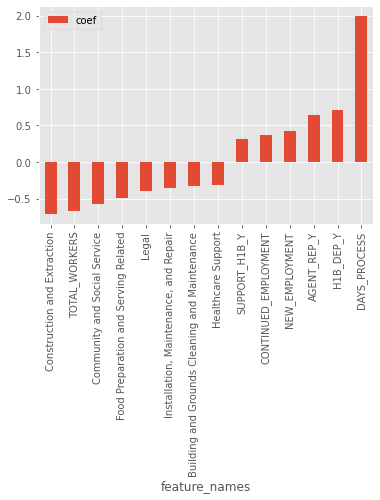

In [40]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


ax = df_coef.plot.bar(y='coef', x = 'feature_names')
plt.show()

The dependent variable of logistic regression is binary and the “log-odds” of the dependent variable’s probability is modeled by a linear combination of independent variables:
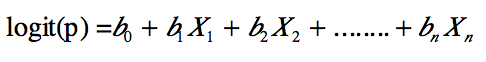
The logit function is defined as the logged odds of probability p:


The odds of an event is the probability of it happens over the probability of it doesn’t happen.<br>
The above variables show the features with the highest weights (coefficients), our target variables are certified = 1, denied=0, our model has been validated using cross-validation to check for overfitting.<br>

### Binary Variables
Most of the prominent weights were from the binary variables the only features that were continuous from the above table was the TOTAL_WORKERS and DAYS_PROCESS.<br>
Based on magnitude of the coefficient one of the largest  binary coefficient is the SOC_GROUP categorical variable of community and social service which tells us if the person being applied for was for this feild of work. It has a coefficient of -0.5920 which means providing all the other metrics are the same, and flipping the SOC_GROUP from Community and Social Service to NOT Community and Social Service, the log-odds of getting certified will decrease by 0.5920.
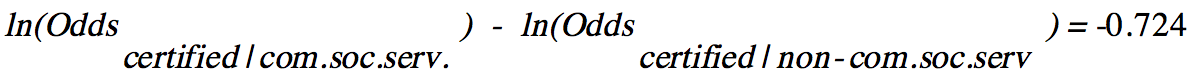

To convert log-odds to odds, we want to take the exponential on both sides of equation which results in the ratio of the odds being 0.507.
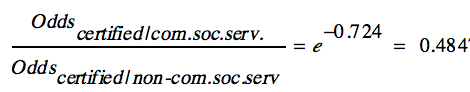
the coefficient of the SOC_GROUP categorical variable community and social service being -0.5920 can be interpreted as the odds of application for an employee in the feild community and social service getting certified over the odds of an applicant that is not in that feild is 0.5531 with all the other variables fixed. In terms of percentage change, the odds community and social service getting certified are xx% lower than the odds for applicant that is not in that feild to get certified this tells us that if if a company wants to appply for such a candidate they may less likely get their candidate certified

### Continuous variables (Standardised)

One common pre-processing step when performing logistic regression is to scale the independent variables to the same level (zero mean and unit variance). The motivation of this type of scaling, named standardization, is to make the feature coefficient scales comparable with each other.<br>
<br>To get the standardized coefficients back to odds ratio with interpretable units we convert the standardized unit back to the original unit of the feature. The most prominent continuous variable in our study is DAYS_PROCESS with standard deviation of 1.66 from the table value called std_dev from the scaling algorithm, and the fitted logistic regression gives this feature a standardized coefficient of 1.9421. This means by increasing one standardized unit of DAYS_PROCESS, the odds ratio of getting certified is exp(1.9421) = 6.9734 (i.e. the odds of getting certified increase by 597.34%).<br>
<br>From the scaling transformation we know that one standardized unit of age equals to 1.66 days, which is the standard deviation of days before the transformation. Plugging this information back, we can conclude that increasing the DAYS_PROCESS by 1.66 will lead to an increase of odds of getting certified by 597.34%.

### Other prominent Interpretations

In [41]:
cont_vars = ['TOTAL_WORKERS','ANNUALIZED_PREVAILING_WAGE', 
           'PREVAILING_WAGE', 'ANNUALIZED_WAGE_RATE_OF_PAY',
                'WAGE_RATE_OF_PAY','DAYS_PROCESS']

feat = list(df_coef['feature_names'])
ods = list(df_coef['odds'])
cofs = list(df_coef['coef'])
inter = zip(ods,feat,cofs)

for ods,feature,cof in inter:
    od = round((ods*100)-100,2)
    if  cof >0 and feature not in cont_vars:
        print('The odds of',feature,'getting certified over the alternative is', od,'%')

The odds of SUPPORT_H1B_Y getting certified over the alternative is 37.46 %
The odds of CONTINUED_EMPLOYMENT getting certified over the alternative is 44.23 %
The odds of NEW_EMPLOYMENT getting certified over the alternative is 51.81 %
The odds of AGENT_REP_Y getting certified over the alternative is 91.01 %
The odds of H1B_DEP_Y getting certified over the alternative is 104.48 %


In [42]:
feat = list(df_coef['feature_names'])
ods = list(df_coef['odds'])
cofs = list(df_coef['coef'])
scale = list(round(df_coef['std_dev'],4))
inter = zip(ods,feat,cofs,scale)

for ods,feature,cof,scale in inter:
    od = round((ods*100)-100,2)
    if  od >0 and feature in cont_vars:
        print('Increasing the',feature, 'by' ,scale, 'will lead to an increase of odds of getting certified by', od,'%')

Increasing the DAYS_PROCESS by 1.6567 will lead to an increase of odds of getting certified by 631.06 %
